# Coupled qubits characterization

.. Note::
        This notebook uses some python helper functions and example data. You can find both in a zipfile accessible with this link: [gitlab](https://gitlab.com/qblox/packages/software/qblox_instruments_docs/-/blob/master/docs/applications/quantify/example_data_and_utils.zip).

The experiments of this tutorial are meant to be executed with a Qblox Cluster controlling a flux-tunable transmon system.

The experiments can also be executed using a dummy Qblox device that is created via an instance of the `Cluster` class, and is initialized with a dummy configuration. However, when using a dummy device, the analysis will not work because the experiments will return `np.nan` values. In this case, example data is loaded from the `"./example_data/"` directory.

## Hardware setup
In this section we configure the hardware configuration which specifies the connectivity of our system.

### Configuration file

This is a template hardware configuration file for a 2-qubit system (we name the qubits `q0` and `q1`), with dedicated flux-control lines.

The hardware setup is as follows, by cluster slot:
1. **QCM-RF**
    - Drive line for `q0` using fixed 80 MHz IF.
    - Drive line for `q1` using fixed 80 MHz IF.
2. **QCM**
    - Flux line for `q0`.
    - Flux line for `q1`.
6. **QRM-RF**
    - Shared readout line for `q0`/`q1` using a fixed LO set at 7.5 GHz.

Note that in the hardware configuration below the mixers are uncorrected, but for high fidelity experiments this should also be done for all the modules.

In [1]:
from __future__ import annotations

hardware_cfg = {
    "backend": "quantify_scheduler.backends.qblox_backend.hardware_compile",
    "cluster0": {
        "sequence_to_file": False,  # Boolean flag which dumps waveforms and program dict to JSON file
        "ref": "internal",  # Use shared clock reference of the cluster
        "instrument_type": "Cluster",
        # ============ DRIVE ============#
        "cluster0_module6": {
            "instrument_type": "QCM_RF",
            "complex_output_0": {
                "output_att": 0,
                "dc_mixer_offset_I": 0.0,
                "dc_mixer_offset_Q": 0.0,
                "portclock_configs": [
                    {
                        "port": "q0:mw",
                        "clock": "q0.01",
                        "interm_freq": 80e6,
                        "mixer_amp_ratio": 1.0,
                        "mixer_phase_error_deg": 0.0,
                    }
                ],
            },
            "complex_output_1": {
                "output_att": 0,
                "dc_mixer_offset_I": 0.0,
                "dc_mixer_offset_Q": 0.0,
                "portclock_configs": [
                    {
                        "port": "q1:mw",
                        "clock": "q1.01",
                        "interm_freq": 80e6,
                        "mixer_amp_ratio": 1.0,
                        "mixer_phase_error_deg": 0.0,
                    }
                ],
            },
        },
        # ============ FLUX ============#
        "cluster0_module2": {
            "instrument_type": "QCM",
            "real_output_0": {"portclock_configs": [{"port": "q0:fl", "clock": "cl0.baseband"}]},
            "real_output_1": {"portclock_configs": [{"port": "q1:fl", "clock": "cl0.baseband"}]},
        },
        # ============ READOUT ============#
        "cluster0_module8": {
            "instrument_type": "QRM_RF",
            "complex_output_0": {
                "output_att": 0,
                "input_att": 0,
                "dc_mixer_offset_I": 0.0,
                "dc_mixer_offset_Q": 0.0,
                "lo_freq": 7.5e9,
                "portclock_configs": [
                    {
                        "port": "q0:res",
                        "clock": "q0.ro",
                        "mixer_amp_ratio": 1.0,
                        "mixer_phase_error_deg": 0.0,
                    },
                    {
                        "port": "q1:res",
                        "clock": "q1.ro",
                        "mixer_amp_ratio": 1.0,
                        "mixer_phase_error_deg": 0.0,
                    },
                ],
            },
        },
    },
}

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/tools.html#api-pnp) for more info).

In [2]:
!qblox-pnp list

Devices:
 - 10.10.200.13: cluster_mm 0.6.1 with name "QSE_1" and serial number 00015_2321_005
 - 10.10.200.42: cluster_mm 0.6.2 with name "QAE_1" and serial number 00015_2320_004
 - 10.10.200.43: cluster_mm 0.6.2 with name "QAE_2" and serial number 00015_2206_003
 - 10.10.200.50: cluster_mm 0.6.1 with name "dd0" and serial number 00015_2219_003
 - 10.10.200.53: cluster_mm 0.6.1 with name "cluster-mm" and serial number 00015_2320_003
 - 10.10.200.70: cluster_mm 0.6.1 with name "cluster-mm" and serial number 123-456-789


In [3]:
cluster_ip = None  # To run this tutorial on hardware, fill in the IP address of the cluster here
cluster_name = "cluster0"

### Connect to Cluster

We now make a connection with the Cluster.

In [4]:
# Close the chosen QCodes instrument to prevent name clash
import contextlib
from pathlib import Path

from qcodes.instrument import Instrument

from qblox_instruments import Cluster, ClusterType

with contextlib.suppress(KeyError):
    Cluster.find_instrument(cluster_name).close()

cluster = Cluster(
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg={
        2: ClusterType.CLUSTER_QCM,
        4: ClusterType.CLUSTER_QRM,
        6: ClusterType.CLUSTER_QCM_RF,
        8: ClusterType.CLUSTER_QRM_RF,
    }
    if cluster_ip is None
    else None,
)

### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters and repeats startup calibration, so resetting between experiments is usually not desirable.

In [5]:
cluster.reset()
print(cluster.get_system_state())

Status: CRITICAL, Flags: TEMPERATURE_OUT_OF_RANGE, Slot flags: SLOT2_TEMPERATURE_OUT_OF_RANGE, SLOT4_TEMPERATURE_OUT_OF_RANGE, SLOT6_TEMPERATURE_OUT_OF_RANGE, SLOT8_TEMPERATURE_OUT_OF_RANGE


Note that a dummy cluster will raise error flags, this is expected behavior and can be ignored.

## Experiment setup

### Quantum device settings
Here we initialize our `QuantumDevice` and our qubit parameters,  checkout this [tutorial](https://quantify-os.org/docs/quantify-scheduler/dev/tutorials/Operations%20and%20Qubits.html) for further details.

In short, a `QuantumDevice` contains device elements where we save our found parameters.

In [6]:
import contextlib

from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement

# Close QCoDeS instruments with conflicting names
for name in ["device_2q", "q0", "q1"]:
    with contextlib.suppress(KeyError):
        Instrument.find_instrument(name).close()


q0 = BasicTransmonElement("q0")
q0.measure.acq_channel(0)

q1 = BasicTransmonElement("q1")
q1.measure.acq_channel(1)

quantum_device = QuantumDevice("device_2q")
quantum_device.hardware_config(hardware_cfg)

quantum_device.add_element(q0)
quantum_device.add_element(q1)

### Set calibrations

This tutorial explicitly only deals with 2-qubit experiments. As such, we assume that both the qubits and their resonators have already been characterized.
For information on how to do this, please see the single transmon qubit tutorial.
In order to use this tutorial on your own system, you must first change the calibrated values to match your own system.

For the sake of this tutorial, we will use some template values for both qubits.


In [7]:
from utils.tutorial_utils import show_parameters

# ============ READOUT ============ #
q0.reset.duration(100e-6)
q0.measure.acq_delay(100e-9)
q0.measure.pulse_amp(0.05)
q0.measure.pulse_duration(2e-6)
q0.measure.integration_time(1.9e-6)

q1.reset.duration(100e-6)
q1.measure.acq_delay(100e-9)
q1.measure.pulse_amp(0.05)
q1.measure.pulse_duration(2e-6)
q1.measure.integration_time(1.9e-6)

q0.clock_freqs.readout(7.6e9)
q1.clock_freqs.readout(7.7e9)

# ============ DRIVE ============ #
q0.rxy.amp180(0.1)
q0.rxy.motzoi(0.05)
q0.rxy.duration(40e-9)

q1.rxy.amp180(0.1)
q1.rxy.motzoi(0.05)
q1.rxy.duration(40e-9)

q0.clock_freqs.f01(5.1e9)
q1.clock_freqs.f01(5.2e9)

show_parameters(q0, q1)

                                  Type  Unit            q0            q1
Parameter                                                               
pulse_type                     measure         SquarePulse   SquarePulse
pulse_amp                      measure                0.05          0.05
pulse_duration                 measure   (s)      0.000002      0.000002
acq_channel                    measure                   0             1
acq_delay                      measure   (s)     0.0000001     0.0000001
integration_time               measure   (s)     0.0000019     0.0000019
reset_clock_phase              measure                True          True
acq_weights_a                  measure                None          None
acq_weights_b                  measure                None          None
acq_weights_sampling_rate      measure                None          None
acq_weight_type                measure                 SSB           SSB
acq_rotation                   measure             

### Configure measurement control loop
We will use a `MeasurementControl` object for data acquisition as well as an `InstrumentCoordinator` for controlling the instruments in our setup.

The `PlotMonitor` is used for live plotting.

All of these are then associated with the `QuantumDevice`.

In [8]:
from quantify_core.measurement.control import MeasurementControl
from quantify_core.visualization.pyqt_plotmon import PlotMonitor_pyqt as PlotMonitor
from quantify_scheduler.instrument_coordinator import InstrumentCoordinator
from quantify_scheduler.instrument_coordinator.components.qblox import ClusterComponent


def configure_measurement_control_loop(
    device: QuantumDevice, cluster: Cluster, live_plotting: bool = False
) -> tuple:
    # Close QCoDeS instruments with conflicting names
    for name in [
        "PlotMonitor",
        "meas_ctrl",
        "ic",
        "ic_generic",
        f"ic_{cluster.name}",
    ] + [f"ic_{module.name}" for module in cluster.modules]:
        with contextlib.suppress(KeyError):
            Instrument.find_instrument(name).close()

    meas_ctrl = MeasurementControl("meas_ctrl")
    ic = InstrumentCoordinator("ic")

    # Add cluster to instrument coordinator
    ic_cluster = ClusterComponent(cluster)
    ic.add_component(ic_cluster)

    if live_plotting:
        # Associate plot monitor with measurement controller
        plotmon = PlotMonitor("PlotMonitor")
        meas_ctrl.instr_plotmon(plotmon.name)

    # Associate measurement controller and instrument coordinator with the quantum device
    device.instr_measurement_control(meas_ctrl.name)
    device.instr_instrument_coordinator(ic.name)

    return (meas_ctrl, ic)


meas_ctrl, instrument_coordinator = configure_measurement_control_loop(quantum_device, cluster)

### Set data directory
This directory is where all of the experimental data as well as all of the post processing will go.

In [9]:
import quantify_core.data.handling as dh

# Enter your own dataset directory here!
dh.set_datadir(Path("example_data").resolve())

### Configure external flux control
We need to have some way of controlling the external flux.

This can be done by setting an output bias on a module of the cluster which is then connected to the flux-control line.

```python
    # e.g. nullify external flux by setting current to 0 A
    cluster.module2.out0_current(0.0)
```

Here we are nullifying the external flux on both qubits.

In [10]:
from utils.tutorial_utils import show_args

from quantify_scheduler.helpers.collections import find_port_clock_path


def find_flux_settable(qubit: BasicTransmonElement) -> callable:
    """Return flux port voltage offset for qubit."""
    path = find_port_clock_path(
        quantum_device.hardware_config(), qubit.ports.flux(), "cl0.baseband"
    )
    module = getattr(cluster, path[1].split("_")[1])
    settable = getattr(module, f"out{path[2].split('_')[-1]}_offset")
    return settable


flux_settables = {q.name: find_flux_settable(q) for q in (q0, q1)}

for flux_settable in flux_settables.values():
    flux_settable(0.0)

show_args(flux_settables)

q0 = cluster0_module2_out0_offset
q1 = cluster0_module2_out1_offset


In [11]:
flux_settables[q0.name](0.0)  # enter your own value here for qubit 0
flux_settables[q1.name](0.0)  # enter your own value here for qubit 1

### Activate NCO delay compensation
Compensate for the digital propagation delay for each qubit (i.e each sequencer)

For more info, please see: https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/sequencer.html#Sequencer.nco_prop_delay_comp

To avoid mismatches between modulation and demodulation, the delay between any readout frequency or phase changes and the next acquisition should be equal or greater than the total propagation delay (146ns + user defined value).

In [12]:
for i in range(6):
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp_en(True)
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp(10)

### Set attenuation
We ought to make sure that our excitation and readout pulses have the appropriate power. Since we are assuming that the qubits and resonators have already been individually characterised, we use the same attenuation that we used in the single transmon qubit tutorial.

In [13]:
from utils.tutorial_utils import set_drive_attenuation, set_readout_attenuation

set_readout_attenuation(quantum_device, q0, out_att=50, in_att=0)
set_readout_attenuation(quantum_device, q1, out_att=50, in_att=0)

set_drive_attenuation(quantum_device, q0, out_att=18)
set_drive_attenuation(quantum_device, q1, out_att=18)

## Experiments

As in the single qubit tuneup tutorial, the sweep setpoints for all experiments in this section are only examples. The sweep setpoints should be changed to match your own system.
In this section we assume that each individual qubit has already been characterized, and that they have been biased to their sweetspots.

We will examine the flux response of the 2-qubit system. By "flux response" we mean the measured response of the system when the parameterization of a flux pulse is varied.

We consider two separate experiments which have their own separate parameterizations, they are:

1. Controlled phase calibration (a.k.a. two-qubit Chevron experiment)
    - Used to measure coupling strength between the two qubits.
    - Used to find the location of the $|11\rangle \leftrightarrow |02\rangle$ avoided crossing.
2. Conditional oscillations
    - Used to measure the conditional phase of the controlled phase gate.
    - Used to estimate leakage to $|02\rangle$.
    - Can also be used to measure single-qubit phases on the individual qubits.

In both of these experiments, we apply the flux pulse on the flux-control line of `q1` (on top of the sweetspot bias) which we take to be the qubit with the *higher* frequency, i.e. $\omega_1$ > $\omega_0$.

### Controlled phase calibration

In [14]:
import numpy as np

from quantify_scheduler.operations.gate_library import Measure, Reset, X
from quantify_scheduler.operations.pulse_library import SquarePulse
from quantify_scheduler.schedules.schedule import Schedule


def chevron_cz_sched(
    lf_qubit: str,
    hf_qubit: str,
    amplitudes: np.ndarray,
    duration: float,
    flux_port: str | None = None,
    repetitions: int = 1,
) -> Schedule:
    """https://quantify-quantify-scheduler.readthedocs-hosted.com/en/latest/autoapi/quantify_scheduler/schedules/two_qubit_transmon_schedules."""
    sched = Schedule("Two-qubit Chevron CZ schedule", repetitions)

    # Ensure amplitudes is an iterable when passing a float
    amplitudes = np.asarray(amplitudes)
    amplitudes = amplitudes.reshape(amplitudes.shape or (1,))

    # Set flux port
    flux_port = flux_port if flux_port is not None else f"{hf_qubit}:fl"

    for acq_index, amp in enumerate(amplitudes):
        # Reset to |00>
        sched.add(Reset(lf_qubit, hf_qubit), label=f"Reset {acq_index}")

        # Prepare |11>
        excite_lf = sched.add(X(lf_qubit), label=f"X({lf_qubit}) {acq_index}")
        sched.add(
            X(hf_qubit),
            ref_op=excite_lf,
            ref_pt="start",
            label=f"X({hf_qubit}) {acq_index}",
        )

        # Go to |11> <=> |02> avoided crossing and come back
        sched.add(
            SquarePulse(
                amp=amp,
                duration=duration,
                port=flux_port,
                clock="cl0.baseband",
            ),
            label=f"SquarePulse({flux_port}) {acq_index}",
        )

        # Measure system
        sched.add(
            Measure(lf_qubit, hf_qubit, acq_index=acq_index),
            label=f"Measure({lf_qubit},{hf_qubit}) {acq_index}",
        )

    return sched

In [15]:
from qcodes.parameters import ManualParameter

from quantify_scheduler.gettables import ScheduleGettable

duration = ManualParameter(name="dur", unit="Hz", label="Duration of flux pulse")
amplitude = ManualParameter(name="amp", unit="", label="Amplitude of flux pulse")

amplitude.batched = True
duration.batched = False

chevron_cz_sched_kwargs = dict(
    lf_qubit=q0.name, hf_qubit=q1.name, amplitudes=amplitude, duration=duration
)

gettable = ScheduleGettable(
    quantum_device,
    schedule_function=chevron_cz_sched,
    schedule_kwargs=chevron_cz_sched_kwargs,
    real_imag=False,
    data_labels=[
        "Magnitude lf qubit",
        "Phase lf qubit",
        "Magnitude hf qubit",
        "Phase hf qubit",
    ],
    batched=True,
    num_channels=2,
)

meas_ctrl.gettables(gettable)
show_args(chevron_cz_sched_kwargs, "chevron_cz_sched_kwargs")

chevron_cz_sched_kwargs
lf_qubit   = q0
hf_qubit   = q1
amplitudes = amp
duration   = dur


In [16]:
quantum_device.cfg_sched_repetitions(400)

duration_setpoints = np.arange(4e-9, 100e-9, 4e-9)
amplitude_setpoints = np.linspace(0.05, 0.2, 100)

meas_ctrl.settables([duration, amplitude])
meas_ctrl.setpoints_grid((duration_setpoints, amplitude_setpoints))

chevron_ds = meas_ctrl.run("chevron")
chevron_ds

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 dur 
Batched settable(s):
	 amp 
Batch size limit: 1024



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

<xarray.Dataset>
Dimensions:  (dim_0: 2400)
Coordinates:
    x0       (dim_0) float64 4e-09 4e-09 4e-09 4e-09 ... 9.6e-08 9.6e-08 9.6e-08
    x1       (dim_0) float64 0.05 0.05152 0.05303 0.05455 ... 0.197 0.1985 0.2
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y1       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y2       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y3       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    tuid:                             20240108-135108-287-0eeead
    name:                             chevron
    grid_2d:                          True
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             24
    ylen:                             100

In [17]:
# If on dummy, override with old data for analysis
if cluster_ip is None:
    # NOTE: This dataset uses an old version of quantify which specified amplitude in volts.
    chevron_ds = dh.to_gridded_dataset(dh.load_dataset(tuid="20230509-120110-134-51b044"))

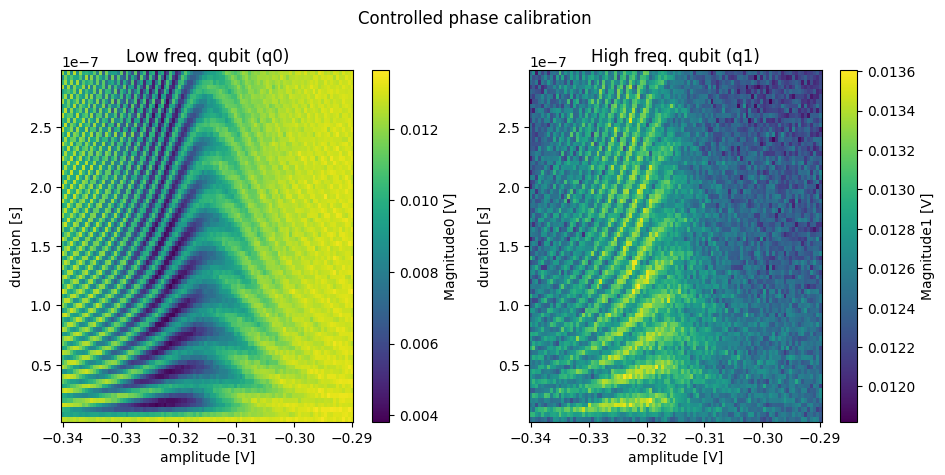

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=plt.figaspect(1 / 2))

# plot only magnitude data of both channels for simplicity
chevron_ds.y0.plot(ax=axs[0])
chevron_ds.y2.plot(ax=axs[1])

axs[0].set_title("Low freq. qubit (q0)")
axs[1].set_title("High freq. qubit (q1)")

fig.suptitle("Controlled phase calibration")

fig.tight_layout()

### Conditional oscillations

In [19]:
from typing import TYPE_CHECKING, Literal

from quantify_scheduler.operations.gate_library import X90, Rxy
from quantify_scheduler.operations.pulse_library import SuddenNetZeroPulse

if TYPE_CHECKING:
    from numpy.typing import NDArray


def conditional_oscillation_sched(
    target_qubit: str,
    control_qubit: str,
    phases: NDArray,
    variant: Literal["OFF", "ON"],
    snz_A: float,
    snz_B: float,
    snz_scale: float,
    snz_dur: float,
    snz_t_phi: float,
    snz_t_integral_correction: float,
    flux_port: str | None = None,
    repetitions: int = 1,
) -> Schedule:
    """
    Make a conditional oscillation schedule to measure conditional phase.

    Parameters
    ----------
    target_qubit
        The name of a qubit, e.g., "q0", the qubit with lower frequency.
    control_qubit
        The name of coupled qubit, the qubit with the higher frequency.
    phases
        An array (or scalar) of recovery phases in degrees.
    variant
        A string specifying whether to excite the control qubit.
    snz_A
        Unitless amplitude of the main square pulse.
    snz_B
        Unitless scaling correction for the final sample of the first
        square and first sample of the second square pulse.
    snz_scale
        Amplitude scaling correction factor of the negative arm of the net-zero pulse.
    snz_dur
        The total duration of the two half square pulses.
    snz_t_phi
        The idling duration between the two half pulses.
    snz_t_integral_correction
        The duration in which any non-zero pulse amplitude needs to be corrected.
    flux_port
        An optional string for a flux port. Default is hf_qubit flux port.
    repetitions
        The amount of times the Schedule will be repeated.

    Returns
    -------
    :
        An experiment schedule.
    """
    sched = Schedule(f"ConditionalOscillation({variant})", repetitions)

    # Ensure phases is an iterable when passing a float
    phases = np.asarray(phases)
    phases = phases.reshape(phases.shape or (1,))

    # Ensure that variant is uppercase for switch
    variant = str.upper(variant)
    if variant not in {"OFF", "ON"}:
        raise ValueError("Schedule variant should be 'OFF' or 'ON'.")

    # Set flux port
    flux_port = flux_port if flux_port is not None else f"{control_qubit}:fl"

    for acq_index, phi in enumerate(phases):
        # Reset to |00>
        sched.add(Reset(target_qubit, control_qubit))

        # Apply a pi/2 pulse on the target qubit
        targ_eq_ref = sched.add(X90(target_qubit))

        if variant == "ON":
            # Also apply a pi pulse on the control qubit
            sched.add(X(control_qubit), ref_op=targ_eq_ref, ref_pt="start")

        # Go to |11> <=> |02> avoided crossing on positive & negative sides
        # using the SuddenNetZeroPulse
        sched.add(
            SuddenNetZeroPulse(
                amp_A=snz_A,
                amp_B=snz_B,
                net_zero_A_scale=snz_scale,
                t_pulse=snz_dur,
                t_phi=snz_t_phi,
                t_integral_correction=snz_t_integral_correction,
                port=flux_port,
                clock="cl0.baseband",
            )
        )

        # Apply a pi/2 recovery pulse on the target qubit
        targ_rec_ref = sched.add(Rxy(theta=90.0, phi=phi, qubit=target_qubit))

        if variant == "ON":
            # Also apply a pi pulse on the control qubit
            sched.add(X(control_qubit), ref_op=targ_rec_ref, ref_pt="start")

        # Measure system
        sched.add(Measure(target_qubit, control_qubit, acq_index=acq_index))

    return sched

In [20]:
phase = ManualParameter(name="ph", unit="deg", label="Recovery phase")
flux_pulse_amplitude = ManualParameter(name="A", unit="", label="Flux pulse amplitude")
scaling_correction = ManualParameter(name="B", unit="", label="Scaling correction")

phase.batched = True
flux_pulse_amplitude.batched = False
scaling_correction.batched = False

conditional_oscillation_sched_kwargs = dict(
    target_qubit=q0.name,
    control_qubit=q1.name,
    phases=phase,
    snz_A=flux_pulse_amplitude,
    snz_B=scaling_correction,
    snz_scale=1.0,
    snz_dur=40e-9,
    snz_t_phi=4e-9,
    snz_t_integral_correction=0.0,
)

gettable_off = ScheduleGettable(
    quantum_device,
    conditional_oscillation_sched,
    schedule_kwargs={**conditional_oscillation_sched_kwargs, **{"variant": "OFF"}},
    real_imag=False,
    batched=True,
    num_channels=2,
)
gettable_on = ScheduleGettable(
    quantum_device,
    conditional_oscillation_sched,
    schedule_kwargs={**conditional_oscillation_sched_kwargs, **{"variant": "ON"}},
    real_imag=False,
    batched=True,
    num_channels=2,
)

meas_ctrl.gettables((gettable_off, gettable_on))
show_args(conditional_oscillation_sched_kwargs, title="conditional_oscillation_sched_kwargs")

conditional_oscillation_sched_kwargs
target_qubit              = q0
control_qubit             = q1
phases                    = ph
snz_A                     = A
snz_B                     = B
snz_scale                 = 1.0
snz_dur                   = 4e-08
snz_t_phi                 = 4e-09
snz_t_integral_correction = 0.0


In [21]:
quantum_device.cfg_sched_repetitions(400)

meas_ctrl.settables([phase, flux_pulse_amplitude, scaling_correction])
meas_ctrl.setpoints_grid((np.linspace(0.0, 360.0, 60), [0.8], [0.5]))

cond_osc_ds = meas_ctrl.run("conditional oscillation")
cond_osc_ds

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 A, B 
Batched settable(s):
	 ph 
Batch size limit: 60



C:\Work\Code\quantify-scheduler\quantify_scheduler\waveforms.py:317: RuntimeWarning: divide by zero encountered in double_scalars
  integral_value = -sum(waveform) / num_corr_samples


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

<xarray.Dataset>
Dimensions:  (dim_0: 60)
Coordinates:
    x0       (dim_0) float64 0.0 6.102 12.2 18.31 ... 341.7 347.8 353.9 360.0
    x1       (dim_0) float64 0.8 0.8 0.8 0.8 0.8 0.8 ... 0.8 0.8 0.8 0.8 0.8 0.8
    x2       (dim_0) float64 0.5 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5 0.5 0.5
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y1       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y2       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y3       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y4       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y5       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y6       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    y7       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    tuid:                             20240108-135133-401-5d2b1a
    name:                             conditional oscillation
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

In [22]:
# If on dummy, override with old data for analysis
if cluster_ip is None:
    cond_osc_ds = dh.to_gridded_dataset(dh.load_dataset(tuid="20230509-164908-713-788626"))

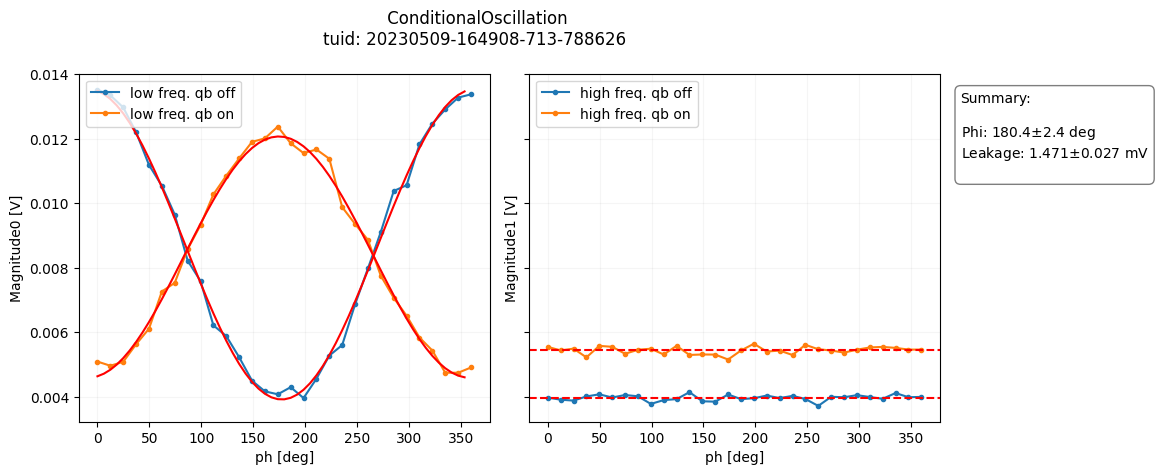

In [23]:
from utils.tutorial_analysis_classes import ConditionalOscillationAnalysis

cond_osc_analysis = ConditionalOscillationAnalysis(
    tuid=cond_osc_ds.attrs["tuid"], dataset=cond_osc_ds
)
cond_osc_analysis.run().display_figs_mpl()

In [24]:
show_parameters(q0, q1)

                                  Type  Unit            q0            q1
Parameter                                                               
pulse_type                     measure         SquarePulse   SquarePulse
pulse_amp                      measure                0.05          0.05
pulse_duration                 measure   (s)      0.000002      0.000002
acq_channel                    measure                   0             1
acq_delay                      measure   (s)     0.0000001     0.0000001
integration_time               measure   (s)     0.0000019     0.0000019
reset_clock_phase              measure                True          True
acq_weights_a                  measure                None          None
acq_weights_b                  measure                None          None
acq_weights_sampling_rate      measure                None          None
acq_weight_type                measure                 SSB           SSB
acq_rotation                   measure             

In [25]:
import rich

rich.print(quantum_device.hardware_config())

{
    'backend': 'quantify_scheduler.backends.qblox_backend.hardware_compile',
    'cluster0': {
        'sequence_to_file': False,
        'ref': 'internal',
        'instrument_type': 'Cluster',
        'cluster0_module6': {
            'instrument_type': 'QCM_RF',
            'complex_output_0': {
                'output_att': 18,
                'dc_mixer_offset_I': 0.0,
                'dc_mixer_offset_Q': 0.0,
                'portclock_configs': [
                    {
                        'port': 'q0:mw',
                        'clock': 'q0.01',
                        'interm_freq': 80000000.0,
                        'mixer_amp_ratio': 1.0,
                        'mixer_phase_error_deg': 0.0
                    }
                ]
            },
            'complex_output_1': {
                'output_att': 18,
                'dc_mixer_offset_I': 0.0,
                'dc_mixer_offset_Q': 0.0,
                'portclock_configs': [
                    {
                        'port': 'q1:mw',
                        'clock': 'q1.01',
                        'interm_freq': 80000000.0,
                        'mixer_amp_ratio': 1.0,
                        'mixer_phase_error_deg': 0.0
                    }
                ]
            }
        },
        'cluster0_module2': {
            'instrument_type': 'QCM',
            'real_output_0': {'portclock_configs': [{'port': 'q0:fl', 'clock': 'cl0.baseband'}]},
            'real_output_1': {'portclock_configs': [{'port': 'q1:fl', 'clock': 'cl0.baseband'}]}
        },
        'cluster0_module8': {
            'instrument_type': 'QRM_RF',
            'complex_output_0': {
                'output_att': 50,
                'input_att': 0,
                'dc_mixer_offset_I': 0.0,
                'dc_mixer_offset_Q': 0.0,
                'lo_freq': 7500000000.0,
                'portclock_configs': [
                    {'port': 'q0:res', 'clock': 'q0.ro', 'mixer_amp_ratio': 1.0, 'mixer_phase_error_deg': 0.0},
                    {'port': 'q1:res', 'clock': 'q1.ro', 'mixer_amp_ratio': 1.0, 'mixer_phase_error_deg': 0.0}
                ]
            }
        }
    }
}